## Import Packages

In [1]:
#importing some useful packages
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from sklearn.externals import joblib
from sklearn import svm, grid_search, datasets
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
import random

C:\Users\Mohamed Hussien\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Mohamed Hussien\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Parameters

In [2]:
#parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


#global initial values
frame_num=1
prev_windows=[]
prev_prev_windows=[]


## helper functions

In [3]:
#helper functions

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """compute color histogram features 
    This will return histogram features for the input image 
    source: from the quizzes"""
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    """compute color binned color features 
    This will return binned color features for the input image 
    source: from the quizzes"""
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """compute color histogram features 
    This will return histogram features for the input image 
    source: from the quizzes"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """combine all the images features 
    This will return a combined features for the input images 
    source: from the quizzes"""
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


    # just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    """combine all the image features 
    This will return a combined features for the input single image 
    source: from the quizzes"""
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """prepare the slide windows 
    This will return all the slide windows in the input image 
    source: from the quizzes"""
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """draw the boxes on image 
    This will return the image with boxes drawn on it  
    source: from the quizzes"""
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def normalization(X):
    """normalize the features 
    This will return the normalized features
    to make all the features has the same importance
    and it will save the scaler
    source: from the quizzes"""
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    scaler = pickle.dumps(X_scaler)
    joblib.dump(X_scaler, 'scaler.pkl') 
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X


def combine_normalization(car_features,notcar_features):
    """comined the normalized features 
    This will return the comined normalized features   
    source: from the quizzes"""
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # normalization
    scaled_X = normalization(X)
    return scaled_X


def search_windows(img, windows, clf,scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """search in all input windows
    This will return the windows that the classifier classify them as a vehicle   
    source: from the quizzes"""

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



def add_heat(heatmap, bbox_list):
    """make a heatmap from boxes 
    This will return a heatmap from the input boxes   
    source: from the quizzes"""
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes



def apply_threshold(heatmap, threshold):
    """apply the threshold to the heatmap 
    This will return the binarized image after applying the input threshold to the input heatmap   
    source: from the quizzes"""

    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    """draw the labels as boxes 
    This will return the image with boxes drawn on it that represent the vehicles positions   
    source: from the quizzes"""

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# classifier trainaning
---

## import data set

In [4]:
#import data set
cars = glob.glob('vehicles\*\*.png')
notcars = glob.glob('non-vehicles\*\*.png')

## Preprocessing

In [ ]:
#preprocessing

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

scaled_X=combine_normalization(car_features,notcar_features)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Training

In [ ]:
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

## saving classifer

In [ ]:
#save the classifier
joblib.dump(svc, 'svm_clf.pkl')

# Prediction
---

## loading classifier & scaler

In [5]:
#load classifier
clf = joblib.load('svm_clf.pkl') 
#load scaler
scaler = joblib.load('scaler.pkl') 

## frame prediction

In [6]:
def frame_predict(image):
    """predict vehicles in the frame 
    This will return the the input image with drawn rectagles represent the predicted vehicles  
    source: from the quizzes"""

    #needed global variables
    global frame_num
    global prev_windows
    global prev_prev_windows
    global windows_list
    #dealing with jpg images
    img=image
    image = image.astype(np.float32)/255
    
    #define the search windows for the first frame
    if frame_num==1:
        windows_list=[]
        #loop fro diffrent scales
        for window_size in [64,128,256,512,1024]:
            windows=slide_window(image, x_start_stop=[0,image.shape[1]], y_start_stop=[int(image.shape[0]/2),image.shape[0]], xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
            for window in windows: 
                windows_list.append(window)
                #give a high weight for the small windows
                if (window_size==64)|(window_size==128):
                    windows_list.append(window)
                if (window_size==64):
                    windows_list.append(window)
                    windows_list.append(window)
        
    #search for vehicles in all windows
    on_windows= search_windows(image, windows_list, clf, scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    if on_windows==[]:
        on_windows=[((0,0),(0,0))]
    
    #for the first frame consider the previous frames windows as the current ones        
    if frame_num==1:
        frame_num=0
        prev_windows=on_windows
        prev_prev_windows=on_windows

    #take the current ,previous and the previous of previous in consideration
    current_windows=on_windows
    on_windows=np.concatenate((on_windows,prev_windows,prev_prev_windows))

    #make the current windows are the previous  , and the previous are the previous of the previous
    prev_prev_windows=prev_windows
    prev_windows=current_windows
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,on_windows)
 
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,13) #11 for video

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

# Visualization
---

### examples

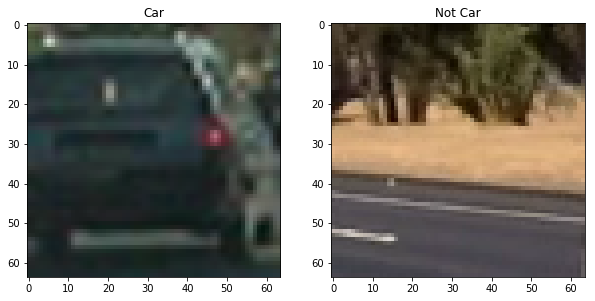

In [7]:
car_ex= mpimg.imread(cars[random.randint(0,len(cars))])
notcar_ex= mpimg.imread(notcars[random.randint(0,len(cars))])
plt.figure(figsize=(10,20)) 
plt.subplot(1,2,1)
plt.title('Car')
plt.imshow(car_ex)
plt.subplot(1,2,2)
plt.title('Not Car')
plt.imshow(notcar_ex)
plt.savefig('writeup_images/1.jpg', bbox_inches='tight')
plt.show()

### HOG visualization

C:\Users\Mohamed Hussien\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


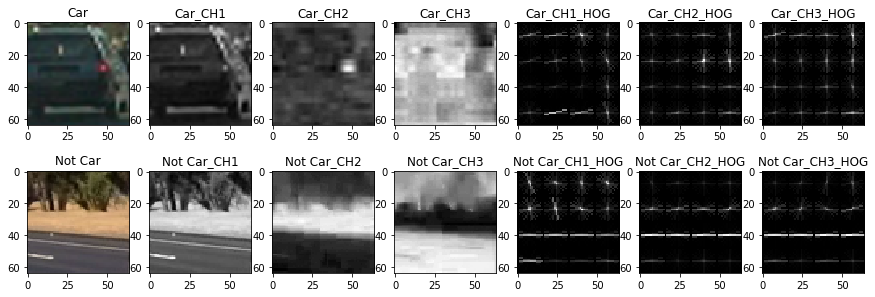

In [8]:
car_ex_YCrCb=cv2.cvtColor(car_ex, cv2.COLOR_RGB2YCrCb)
notcar_ex_YCrCb=cv2.cvtColor(notcar_ex, cv2.COLOR_RGB2YCrCb)

plt.figure(figsize=(15,5)) 
plt.subplot(2,7,1)
plt.title('Car')
plt.imshow(car_ex)
plt.subplot(2,7,2)
plt.title('Car_CH1')
plt.imshow(car_ex_YCrCb[:,:,0],cmap='gray')
plt.subplot(2,7,3)
plt.title('Car_CH2')
plt.imshow(car_ex_YCrCb[:,:,1],cmap='gray')
plt.subplot(2,7,4)
plt.title('Car_CH3')
plt.imshow(car_ex_YCrCb[:,:,2],cmap='gray')
plt.subplot(2,7,5)
features,features_img=get_hog_features(car_ex_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Car_CH1_HOG')
plt.imshow(features_img,cmap='gray')
plt.subplot(2,7,6)
features,features_img=get_hog_features(car_ex_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Car_CH2_HOG')
plt.imshow(features_img,cmap='gray')
plt.subplot(2,7,7)
features,features_img=get_hog_features(car_ex_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Car_CH3_HOG')
plt.imshow(features_img,cmap='gray') 

plt.subplot(2,7,8)
plt.title('Not Car')
plt.imshow(notcar_ex)
plt.subplot(2,7,9)
plt.title('Not Car_CH1')
plt.imshow(notcar_ex_YCrCb[:,:,0],cmap='gray')
plt.subplot(2,7,10)
plt.title('Not Car_CH2')
plt.imshow(notcar_ex_YCrCb[:,:,1],cmap='gray')
plt.subplot(2,7,11)
plt.title('Not Car_CH3')
plt.imshow(notcar_ex_YCrCb[:,:,2],cmap='gray')
plt.subplot(2,7,12)
features,features_img=get_hog_features(notcar_ex_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Not Car_CH1_HOG')
plt.imshow(features_img,cmap='gray')
plt.subplot(2,7,13)
features,features_img=get_hog_features(notcar_ex_YCrCb[:,:,1], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Not Car_CH2_HOG')
plt.imshow(features_img,cmap='gray')
plt.subplot(2,7,14)
features,features_img=get_hog_features(notcar_ex_YCrCb[:,:,2], orient, pix_per_cell, cell_per_block, vis=True)
plt.title('Not Car_CH3_HOG')
plt.imshow(features_img,cmap='gray')

plt.savefig('writeup_images/2.jpg', bbox_inches='tight')
plt.show()

### on_windows visualization

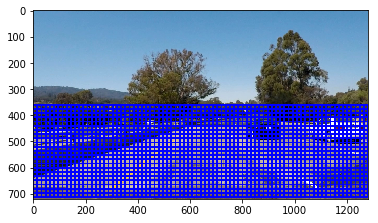

C:\Users\Mohamed Hussien\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


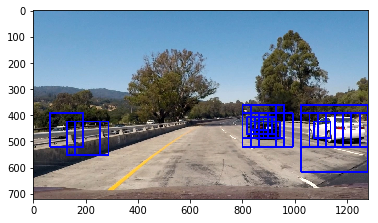

In [14]:
image=mpimg.imread('test_images/test1.jpg')
img=image
image = image.astype(np.float32)/255

#define the search windows for the first frame
if frame_num==1:
    windows_list=[]
    #loop fro diffrent scales
    for window_size in [64,128,256,512,1024]:
        windows=slide_window(image, x_start_stop=[0,image.shape[1]], y_start_stop=[int(image.shape[0]/2),image.shape[0]], xy_window=(window_size, window_size), xy_overlap=(0.75, 0.75))
        for window in windows: 
            windows_list.append(window)
            #give a high weight for the small windows
            if (window_size==64)|(window_size==128):
                windows_list.append(window)
            if (window_size==64):
                windows_list.append(window)
                windows_list.append(window)

draw_img = draw_boxes(img, windows_list, color=(0, 0, 255), thick=6)
plt.figure()
plt.imshow(draw_img)
plt.show()
cv2.imwrite('writeup_images/17.jpg',cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR))                
#search for vehicles in all windows
on_windows= search_windows(image, windows_list, clf, scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, hist_range=(0, 256), orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

draw_img = draw_boxes(img, on_windows, color=(0, 0, 255), thick=6)
plt.figure()
plt.imshow(draw_img)
plt.show()


In [10]:
#loading examples
import os
images_path=os.listdir("test_images/")

C:\Users\Mohamed Hussien\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


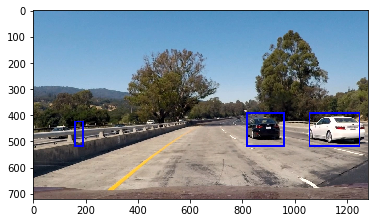

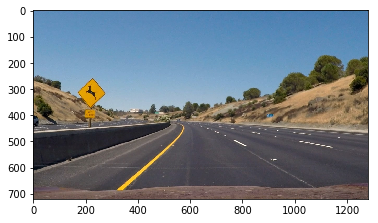

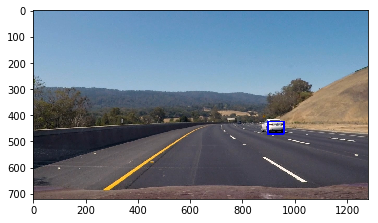

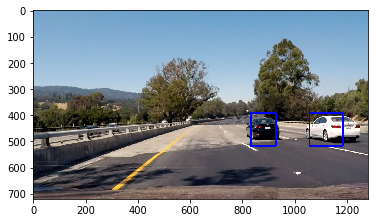

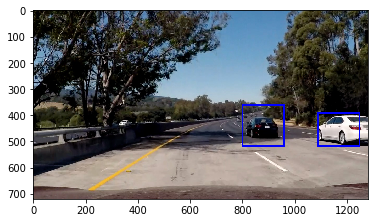

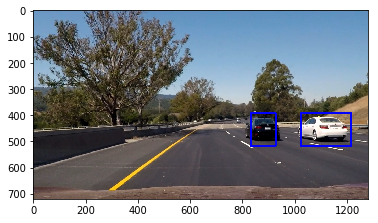

In [11]:
global frame_num
for image_path in images_path:
    frame_num=1
    image= mpimg.imread('test_images/'+image_path)
    draw_img= frame_predict(image)
    plt.figure()
    plt.imshow(draw_img)
    plt.show()
    cv2.imwrite('test_images_output/'+image_path,cv2.cvtColor(draw_img,cv2.COLOR_RGB2BGR))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global frame_num
frame_num=1

white_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(frame_predict) #NOTE: this function expects color images!!
get_ipython().magic('time white_clip.write_videofile(white_output, audio=False)')